# Configuration

In [1]:
# data analysis 
import numpy as np 
import pandas as pd 

# visualization
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import plotly.graph_objects as go

# utilities
import pickle
from tqdm import tqdm
from datetime import datetime

# data reader
import investpy as ip
import pandas_datareader.data as dr

# solver
import gurobipy as gp

# Fetch Data

In [2]:
# # get s&p 500 constituents
# sp500_components_df = pd.read_csv('/Users/iamsikun/Downloads/sp500_components.csv')
# all_tickers_list = sp500_components_df.loc[sp500_components_df.shape[0]-1, 'tickers'].split(',')

In [3]:
# %%time
# # fetch historical data from yahoo finance
# historical = {}
# for ticker in tqdm(all_tickers_list):
#     # cleaning
#     if '.' in ticker:
#         ticker = ticker.replace('.', '-')
#     historical[ticker] = 
# 
# with open('historical.pickle', 'wb') as file:
#     pickle.dump(historical, file)

In [4]:
# load saved file: historical data of S&P500 components
with open('historical.pickle', 'rb') as file:
    historical_dict = pickle.load(file)

In [5]:
# load s&p 500 index
sp_df = dr.DataReader('^GSPC', 'yahoo', start='2010-01-01', end='2022-04-01')

# EDA

## PnL (Profit and Loss) Chart

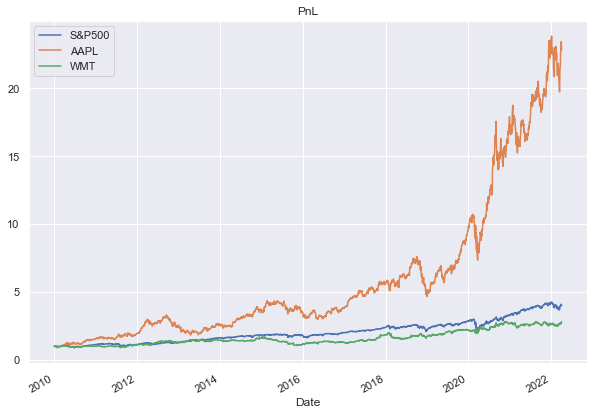

In [6]:
# parameter
stocks_to_plot = ['AAPL', 'WMT']

# calculate cumulative return for index
index_cum_ret_series = sp_df['Close'].pct_change().add(1).cumprod()
index_cum_ret_series.name = 'S&P500'
# calculate cumulative return for stocks
stocks_cum_ret_series_dict = {
    ticker: historical_dict[ticker]['Close'].pct_change().add(1).cumprod() 
    for ticker in stocks_to_plot if ticker in historical_dict.keys()
}
for ticker, series in stocks_cum_ret_series_dict.items():
    series.name = ticker

    
# plot
fig = plt.figure(figsize=(10, 7))
index_cum_ret_series.plot()
for series in stocks_cum_ret_series_dict.values():
    series.plot()
plt.title('PnL')
plt.legend()
plt.show()

# Model Preparation

## Parameters

In [7]:
# data parameters
asof = '2022-04-01'  # the date on which to run the model
return_look_back = 6  # number of months of history to estimate historical return
cov_look_back = 12  # number of months of history to estimate covariance

In [8]:
# parameters processing
return_look_back_days = int(return_look_back * 30)  # turn months into days
cov_look_back_days = int(cov_look_back * 30)  # turn months into days

## Return Calculation

In [9]:
def calculate_annualized_return_for_price_series(price_series: pd.Series) -> float: 
    assert price_series.shape[0] > 1 
    return (1 + (price_series.iloc[-1] - price_series.iloc[0]) / price_series.iloc[0]) ** (12/return_look_back) - 1

return_dict = {
    ticker: calculate_annualized_return_for_price_series(df.loc[:asof].iloc[-return_look_back_days:]['Close'])
    for ticker, df in historical_dict.items()
}

In [10]:
# s&p500 return
sp_return = calculate_annualized_return_for_price_series(sp_df.loc[:asof].iloc[-return_look_back_days:]['Close'])

## Covariance Calculation

In [11]:
def calculate_historical_covariance(return_df: pd.DataFrame) -> pd.DataFrame: 
    return return_df.cov()

cov_df = calculate_historical_covariance(
    pd.DataFrame({ticker: df['Close'] for ticker, df in historical_dict.items()}).pct_change(1).iloc[-cov_look_back_days-1:]
)

In [12]:
# s&p500 volatility
sp_vol = sp_df.Close.pct_change(1).iloc[-cov_look_back_days-1:].std()

# Portfolio Optimization

## Model Input

In [13]:
# bounds
r_l = 0.3  # lower bound for annualized return
s_l = 0.3  # lower bound for sharpe ratio
k = 100  # maximum number of stocks to invest in

# data input
r = np.array([x for x in return_dict.values()])
sigma = cov_df.values

# process sigma to be psd
sigma += np.diag(1e-3*np.ones(sigma.shape[0]))

In [14]:
# indexing
index_map = {index: ticker for index, ticker in enumerate(historical_dict.keys())}
index_arr = np.array([item for item in index_map.keys()])

## Minimum Variance Optimization (MVO)

$$
\begin{align}
\min_{w}\quad & \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2 \\ 
\text{s.t.}\quad & \sum_{i=1}^n r_i w_i \geq r_l \\ 
& \sum_{i=1}^n w_i = 1
\end{align}
$$

In [15]:
class BaseMVO(object): 
    def __init__(self, sigma: np.ndarray, r: np.ndarray, r_l: float, index_arr: np.ndarray = None, 
                index_map: dict = None):
        # parameters
        self.sigma = sigma
        self.r = r 
        self.r_l = r_l
        self.index_arr = np.arange(0, self.r.shape[0], 1) if index_arr is None else index_arr
        self.index_map = {i: i for i in self.index_arr} if index_map is None else index_map      
        
        # attributes: data
        self.sigma_inv = np.linalg.inv(sigma)
        
        # attributes: results
        self.gb_model = None 
        self.w_s = None 
        self.w_s_named = {}
        
    def solve(self, r_l: float = None, method='analytical'):
        """
        :param method: analytical or gurobi
        """
        if method == 'gurobi':
            self.solve_with_gurobi(r_l)
        else: 
            self.solve_analytically(r_l)
            
        return {
            'x': self.w_s, 
            'obj_val': self.obj_val
        }
        
    
    @property
    def criterion(self): 
        return np.dot(self.r - self.r_l, self.sigma_inv.sum(axis=0))
            
    @property
    def volatility(self):
        return np.dot(np.dot(self.w_s, self.sigma), self.w_s) ** 0.5
    
    @property
    def return_(self):
        return np.dot(self.r, self.w_s)
        
    def solve_with_gurobi(self, r_l: float = None):
        # hyperparameters
        self.r_l = r_l if r_l is not None else self.r_l
        
        # initialize model
        self.gb_model= gp.Model()

        # add variables
        w = self.gb_model.addVars(self.index_arr, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS)

        # set objective
        self.gb_model.setObjective(sum([w[i] * w[j] * self.sigma[i, j] for i in index_arr for j in index_arr]), gp.GRB.MINIMIZE)

        # add constraints
        self.gb_model.addConstr(sum([self.r[i] * w[i] for i in index_arr]) >= self.r_l)
        self.gb_model.addConstr(w.sum() == 1)

        # update model
        self.gb_model.update()

        # solve the model
        self.gb_model.optimize()
        
        # update attributes
        self.w_s_named = {self.index_map[index]: var.X for index, var in w.items()}
        self.w_s = np.array([val for val in self.w_s_named.values()])
        self.obj_val = self.gb_model.ObjVal
        
        
    def solve_analytically(self, r_l: float = None):
        # hyperparameters
        self.r_l = r_l if r_l is not None else self.r_l
        
        criterion = self.criterion
        
        if criterion >= 0: 
            self.w_s = self.sigma_inv.sum(axis=1) / self.sigma_inv.sum()
            self.w_s_named = {self.index_map[index]: self.w_s[index] for index in self.index_arr}
            self.obj_val = np.dot(np.dot(self.w_s, self.sigma), self.w_s)
        else: 
            # parameters
            c_rr = np.dot(np.dot(self.r, self.sigma_inv), self.r)
            c_ee = self.sigma_inv.sum()
            c_re = np.dot(self.r, self.sigma_inv.sum(axis=1))
            C_det = c_rr * c_ee - c_re**2
            lambda_s = (self.r_l * c_ee - c_re) / C_det
            mu_s = (-self.r_l * c_re + c_rr) / C_det
            
            # solve
            self.w_s = lambda_s * np.dot(self.sigma_inv, self.r) + mu_s * self.sigma_inv.sum(axis=1)
            self.w_s_named = {self.index_map[index]: self.w_s[index] for index in self.index_arr}
            self.obj_val = np.dot(np.dot(self.w_s, self.sigma), self.w_s)

In [16]:
mvo = BaseMVO(
    sigma=sigma, r=r, r_l=r_l, index_arr=index_arr, index_map=index_map
)

In [17]:
# solve analytically
mvo.solve(r_l=0.7, method='analytically')['obj_val']

4.132977585489942e-05

In [18]:
# solve with gurobi
mvo.solve(r_l=0.7, method='gurobi')['obj_val']

Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-02
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 2 rows, 505 columns and 1010 nonzeros
Model fingerprint: 0x742b0a68
Model has 127765 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-09, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 505 columns, 1010 nonzeros
Presolved model has 127765 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1009
 AA' NZ     : 1.278e+05
 Factor NZ  : 1.283e+05 (roughly 2 MB of memory)
 Factor Ops : 4.331e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     C

4.133897206178727e-05

### Efficient Frontier

In [19]:
# parameters
candidate_lbs = np.arange(0.1, 2, 0.03)
results = [None for _ in candidate_lbs]

# specify model
mvo = BaseMVO(
    sigma=sigma, r=r, r_l=r_l, index_arr=index_arr, index_map=index_map
)

# calculate
for idx, r_l in enumerate(candidate_lbs):
    _ = mvo.solve(r_l=r_l, method='analytically')
    results[idx] = {'lb': r_l, 'vol': mvo.volatility, 'return': mvo.return_}

basic_mvo_data = pd.DataFrame.from_records(results)

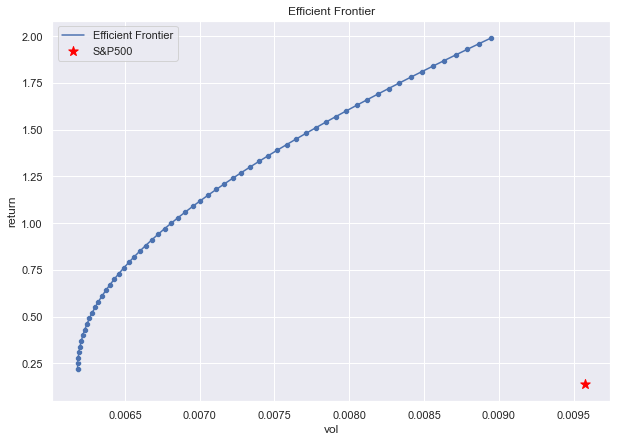

In [20]:
# visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

sns.lineplot(x='vol', y='return', data=basic_mvo_data, label='Efficient Frontier', ax=ax)
sns.scatterplot(x='vol', y='return', data=basic_mvo_data, ax=ax)

ax.scatter(x=[sp_vol], y=[sp_return], color='red', label='S&P500', marker='*', s=100)

ax.legend()
ax.set_title('Efficient Frontier')

plt.show()

### MVO as Multi-objective Programming

$$
\begin{align}
\min_{w}\quad & \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2 - \lambda \sum_{i=1}^n r_i w_i \\ 
\text{s.t.}\quad & \sum_{i=1}^n w_i = 1 \\ 
& w_i\geq 0,\;\forall i=1, \dots, n \\
\end{align}
$$

The equivalent formulation is related to the previous one by:
$$
\begin{aligned}
& \lambda = \frac{1}{|C|} (r_l c_{ee} - c_{re}) \\ 
& |C| = c_{rr}c_{ee} - c_{re}^2 \\
& c_{ee} = e^T \Sigma^{-1} e \\ 
& c_{re} = r^T \Sigma^{-1} e \\ 
\end{aligned}
$$

In [39]:
# equivalent lambda
c_rr = np.dot(np.dot(r, np.linalg.inv(sigma)), r)
c_ee = np.linalg.inv(sigma).sum()
c_re = np.dot(r, np.linalg.inv(sigma).sum(axis=1))
C_det = c_rr * c_ee - c_re**2
lambda_ = (r.sum() - c_re) / C_det

In [16]:
# hyper params
lambda_ = 0.1

# initialize model
mvo= gp.Model()

# add variables
w = mvo.addVars(index_arr, lb=0.0, vtype=gp.GRB.CONTINUOUS)

# set objective
mvo.setObjective(sum([w[i] * w[j] * sigma[i, j] for i in index_arr for j in index_arr]) - lambda_ * sum([r[i] * w[i] for i in index_arr]))

# add constraints
mvo.addConstr(w.sum() == 1)

# update model
mvo.update()

# solve the model
mvo.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 1 rows, 505 columns and 505 nonzeros
Model fingerprint: 0x9fea7d9e
Model has 127765 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 5e-01]
  QObjective range [4e-09, 8e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Interrupt request received
Presolve time: 0.01s
Presolved: 1 rows, 505 columns, 505 nonzeros
Presolved model has 127765 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 504
 AA' NZ     : 1.273e+05
 Factor NZ  : 1.278e+05 (roughly 2 MB of memory)
 Factor Ops : 4.306e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.70333907e+04 -2.74318933e+05  5.03e+05 8.03

## MVO with Cardinality and Performance Bounds (MVOCP)

$$
\begin{align}
\min_{w, y}\quad & \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2 \\ 
\text{s.t.}\quad & \sum_{i=1}^n w_i = 1 \\ 
& w_i \leq y_i,\;\forall i=1, \dots, n \\
& \sum_{i=1}^n y_i \leq k \\ 
& \sum_{i=1}^n r_i w_i \geq s_l \sqrt{\sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2} \\
& w_i \geq 0,\;\forall i=1, \dots, n \\ 
& y_i\in \{0, 1\},\;\forall i=1, \dots, n \\ 
\end{align}
$$

### Gurobi Solution

In [ ]:
# initialize model
mvo= gp.Model()

# add variables
w = mvo.addVars(index_arr, lb=0.0, vtype=gp.GRB.CONTINUOUS)
y = mvo.addVars(index_arr, vtype=gp.GRB.BINARY)

# set objective
mvo.setObjective(sum([w[i] * w[j] * sigma[i, j] for i in index_arr for j in index_arr]))

# add constraints
mvo.addConstr(w.sum() == 1)
mvo.addConstrs(w[i] <= y[i] for i in index_arr)
mvo.addConstr(sum([y[i] for i in index_arr]) <= k)
mvo.addConstr(sum([r[i] * w[i] for i in index_arr])**2 >= (s_l ** 2) * sum([w[i] * w[j] * sigma[i, j] for i in index_arr for j in index_arr]))

# update model
mvo.update()

# solve the model
mvo.params.NonConvex = 2
mvo.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 507 rows, 1010 columns and 2020 nonzeros
Model fingerprint: 0x0dd98f4d
Model has 127765 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 505 continuous, 505 integer (505 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [4e-06, 5e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-09, 8e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve time: 0.11s
Presolved: 255525 rows, 128775 columns, 639819 nonzeros
Presolved model has 127765 quadratic objective terms
Presolved model has 8 quadratic constraint(s)
Presolved model has 127757 bilinear constraint(s)
Variable types: 128270 continuous, 505 integer (505 binary)

Root relaxation: objective 4.503784e-05, 562 iterations, 0.36 seconds (1.57 work unit

### Heuristics

A subproblem of MVOCP is removing cardinality constraint:
$$
\begin{align}
\min_{w}\quad & \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2 \\ 
\text{s.t.}\quad & \sum_{i=1}^n w_i = 1 \\ 
& \sum_{i=1}^n r_i w_i \geq s_l \sqrt{\sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}^2} \\ 
& w_i \geq 0,\;\forall i=1, \dots, n
\end{align}
$$

In [231]:
# initialize model
mvo= gp.Model()

# add variables
w = mvo.addVars(index_arr, lb=-gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS)

# set objective
mvo.setObjective(sum([w[i] * w[j] * sigma[i, j] for i in index_arr for j in index_arr]))

# add constraints
mvo.addConstr(sum([r[i] * w[i] for i in index_arr]) >= r_l)
mvo.addConstr(w.sum() == 1)
mvo.addConstr(sum([r[i] * w[i] for i in index_arr])**2 >= (s_l ** 2) * sum([w[i] * w[j] * sigma[i, j] for i in index_arr for j in index_arr]))

# update model
mvo.update()

# solve the model
mvo.params.NonConvex = 2
mvo.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 2 rows, 505 columns and 1010 nonzeros
Model fingerprint: 0xa52ae5a7
Model has 127765 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e-03, 5e+00]
  QMatrix range    [4e-06, 5e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-09, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.08s
Presolved: 255019 rows, 128271 columns, 638806 nonzeros
Presolved model has 127765 quadratic objective terms
Presolved model has 9 quadratic constraint(s)
Presolved model has 127756 bilinear constraint(s)
Variable types: 128271 continuous, 0 integer (0 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   

In [236]:
w_s = np.array([var.X for index, var in w.items()])

## Visualization

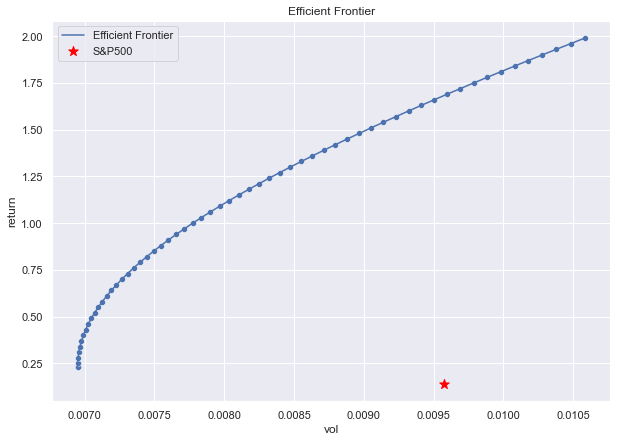

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# base MVO
sns.lineplot(x='vol', y='return', data=basic_mvo_data, label='Efficient Frontier', ax=ax)
sns.scatterplot(x='vol', y='return', data=basic_mvo_data, ax=ax)

# S&P500
ax.scatter(x=[sp_vol], y=[sp_return], color='red', label='S&P500', marker='*', s=100)

# utilities
ax.legend()
ax.set_title('Efficient Frontier')

# plt.show()
plt.savefig('efficient_frontier_with_sp.png')

# Sensitivity Analysis